## Spartial transformer networks tutorial
- How to augment network using a visual attention mechanism called spartial transformer networks.
- Spatial transformer networks are a generalization of differentiable attention to any spatial transformation. Spatial transformer networks (STN for short) allow a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. For example, it can crop a region of interest, scale and correct the orientation of an image. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations.
- [Paper](https://arxiv.org/abs/1506.02025)
- [Blog](https://jamiekang.github.io/2017/05/27/spatial-transformer-networks/)

- One of the best things about STN is the ability to simply plug it into any existing CNN with very little modification.



In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

### Loading the data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# transform
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# Training dataset 
tr_dataset = datasets.MNIST(root='./data', train=True, download=True,
                            transform=transforms)
tst_dataset = datasets.MNIST(root='./data', train=False,
                             transform=transforms)

train_loader = torch.utils.data.DataLoader(dataset=tr_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=tst_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


### Depicting spatial transformer networks 
Spatial transformer networks boils down to three main components
- The localization network is a regular CNN which regress the transformation parameters. The transformation is never learned explicitly from the dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
- The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
- The sampler uses the parameters of the transformation and applies it to the input image.

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, 7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, 5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 *3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 *3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        return x 
    
    def forward(self, x):
        # transform the input
        x = self.stn(x)
        
        # Perform the usual forward pass 
        x = F.relu(F.max_pool2d(self.conv1(x) ,2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
model = Net().to(device)

### Training the model 

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        pred = model(data)
        loss = F.nll_loss(pred, target) # The negative log likelihood loss.
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()
            ))
            

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
             .format(test_loss, correct, len(test_loader.dataset),
                    100. * correct / len(test_loader.dataset)))

### Visualizing the STN results 

In [12]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

Train Epoch: 1 [0/60000 (0%)]	 Loss: 2.293521
Train Epoch: 1 [32000/60000 (53%)]	 Loss: 2.332846


/usr/local/var/pyenv/versions/3.6.8/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.3232, Accuracy: 913/10000 (9%)

Train Epoch: 2 [0/60000 (0%)]	 Loss: 2.346365
Train Epoch: 2 [32000/60000 (53%)]	 Loss: 2.327427

Test set: Average loss: 2.3232, Accuracy: 913/10000 (9%)

Train Epoch: 3 [0/60000 (0%)]	 Loss: 2.282671
Train Epoch: 3 [32000/60000 (53%)]	 Loss: 2.298414

Test set: Average loss: 2.3232, Accuracy: 913/10000 (9%)

Train Epoch: 4 [0/60000 (0%)]	 Loss: 2.325064
Train Epoch: 4 [32000/60000 (53%)]	 Loss: 2.315041

Test set: Average loss: 2.3232, Accuracy: 913/10000 (9%)

Train Epoch: 5 [0/60000 (0%)]	 Loss: 2.331504
Train Epoch: 5 [32000/60000 (53%)]	 Loss: 2.330110

Test set: Average loss: 2.3232, Accuracy: 913/10000 (9%)

Train Epoch: 6 [0/60000 (0%)]	 Loss: 2.330925
Train Epoch: 6 [32000/60000 (53%)]	 Loss: 2.331265

Test set: Average loss: 2.3232, Accuracy: 913/10000 (9%)

Train Epoch: 7 [0/60000 (0%)]	 Loss: 2.297195
Train Epoch: 7 [32000/60000 (53%)]	 Loss: 2.350878

Test set: Average loss: 2.3232, Accuracy: 913/10000 (9%)

Train

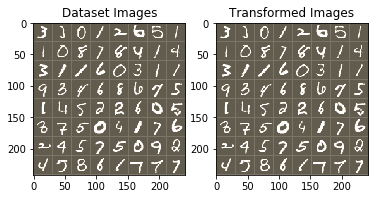

In [20]:
for epoch in range(1, 20+1):
    train(epoch)
    test()

visualize_stn()

plt.ioff()
plt.show()